## handling units for ASPECT output 

The ASPECT notebooks in this repository have not yet touched on units. So in this notebook, we outline a general methodology for handling units and ASPECT data with an emphasis on user configuration. 

The general approach is to use a default mapping of fieldnames to units that the user can override with a configuration json that they create in the directory containing the `vtu` output. 

Some notes and thoughts on ASPECT output:

* The `vtu` files output by ASPECT contain fieldnames, but no information on units. 
* Many of the fields output by ASPECT have standard units (e.g., `T` has units of `K`) but many ASPECT C++ plugins introduce new fields, so any attempt to make a comprehensive list will soon be outdated. 
* All ASPECT calculations are done in the MKS system of units, but the units for time can be output in `s` or `Myrs`.
* ASPECT users should be able to easily load existing output, so rather than considering a modification of the ASPECT write routines to include metadata for units, we focus on how to load ASPECT output as it is now. 

## data

We'll be using ASPECT output from: Data source: DOI 10.17605/OSF.IO/TEJM4 Title: Edge-Driven Convection and Mantle Wind Models Beneath Madagascar Authors: Tahiry Rajaonarison, Sarah Stamps, Stewart Fishwick, Sascha Brune, Anne Glerum, Jiashun Hu.

To run notebook: download and unpack, set environment variable "ASPECTdatadir" to the directory containing the unzipped directory

## overview 

we store a default mapping for units in a json, `aspect_default_units.json`. This mapping could be stored in the future `yt` frontend for ASPECT. The benefit to using a json file rather than a python dict is that the user-

In [1]:
import yt
import unyt
import os
import json 
import numpy as np
import xmltodict
import meshio

The default units json contains the following:
```
{
  "T": "K",
  "p": "Pa",
  "viscosity": "Pa*s",
  "strain_rate": "1 / s",
  "velocity": "m / s",
  "time" : "s", 
  "length" : "m" 
}
```

For each fieldname, we have a declaration of the units in a `unyt`-compatible string. When loading the field data from the vtu files, we'll first check this json for the units of each field. If `aspect_units.json` exists in the directory of the data, then any fields defined there will override the default values. If a field is not found in either file, then we'll print a warning and not set any units. 

The default units can be loaded into a python dictionary as follows:

In [2]:
with open('aspect_default_units.json') as jstream:
    default_units = json.load(jstream)

In [3]:
print(default_units)

{'T': 'K', 'p': 'Pa', 'viscosity': 'Pa*s', 'strain_rate': '1 / s', 'velocity': 'm / s', 'time': 's', 'length': 'm'}


So if we had a numpy array of `T` values, we could build a `unyt` array as follows:

In [4]:
T = np.linspace(500,1800,5)
T = unyt.unyt_array(T,default_units['T'])
T

unyt_array([ 500.,  825., 1150., 1475., 1800.], 'K')

In [5]:
T.to("Celsius")

unyt_array([ 226.85,  551.85,  876.85, 1201.85, 1526.85], 'degC')

and now `YTArray` is a `unyt_array`: 

In [6]:
eta = np.logspace(18,25,8)
eta = yt.YTArray(eta,default_units['viscosity'])
eta

unyt_array([1.e+18, 1.e+19, 1.e+20, 1.e+21, 1.e+22, 1.e+23, 1.e+24,
            1.e+25], 'Pa*s')

In [7]:
eta.unit_quantity

unyt_quantity(1, 'Pa*s')

### a data loader

same as in other notebooks, but with the addition of a `units_lookup` dict that gets populated by the `_get_units_lookup` function. And `parseNodeData` now populates the `node_data` dictionary with `YTArray` objects in order to pass the units. 

In [8]:
class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']  
        self.units_lookup = self._get_units_lookup()
        
        self.connectivity = None
        self.coordinates = None
        self.node_data = None 
        
    def _get_units_lookup(self):
        with open('aspect_default_units.json') as jstream:
            units = json.load(jstream)
            
        # look for the user file 
        filename = os.path.join(self.dataDir,'aspect_units.json')
        
        user_units = {}
        if os.path.isfile(filename):
            with open(filename) as jstream:
                    user_units = json.load(jstream)
            
        # set the units dict (will override defaults with user values)
        for key,val in user_units.items():
            units[key] = val 
            
        return units 
    
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 

        con_offset=-1
        for mesh_id,src in enumerate(self.pXML['VTKFile']['PUnstructuredGrid']['Piece']):    
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.            
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
            
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 

        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        connectivity=meshPiece.cells_dict['hexahedron'] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}
        def rshpData(data1d):
            return np.reshape(data1d[con1d],conn_shp)
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                
                units = self.units_lookup.get(nm,'1')
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=yt.YTArray(rshpData(point_data[nm][:,component]),units)
                else:
                    # just a scalar!                     
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=yt.YTArray(rshpData(point_data[nm]),units)
    
        return node_data      


In [9]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','../'),'edc_driven_convection_madagascar',
                     'edc_driven_convection_madagascar','solution')
pFile=os.path.join(DataDir,'solution-00015.pvtu')
pvuData=pvuFile(pFile)
pvuData.load()

In [10]:
ds = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data,
    length_unit = pvuData.units_lookup['length'],
    time_unit = pvuData.units_lookup['time']
)  


yt : [INFO     ] 2020-08-26 08:47:11,187 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-08-26 08:47:11,187 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-08-26 08:47:11,188 Parameters: domain_left_edge          = [ 2679220.40116885  2679220.40116884 -3272029.00399254]
yt : [INFO     ] 2020-08-26 08:47:11,189 Parameters: domain_right_edge         = [5653600.91489411 5653600.91489411 -736270.69874229]
yt : [INFO     ] 2020-08-26 08:47:11,189 Parameters: cosmological_simulation   = 0.0


In [11]:
dd = ds.all_data()

yt : [INFO     ] 2020-08-26 08:47:11,555 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-08-26 08:47:11,555 ylim = -3272029.003993 -736270.698742
yt : [INFO     ] 2020-08-26 08:47:11,556 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-08-26 08:47:11,557 ylim = -3272029.003993 -736270.698742
yt : [INFO     ] 2020-08-26 08:47:11,558 Making a fixed resolution buffer of (('connect1', 'T')) 800 by 800



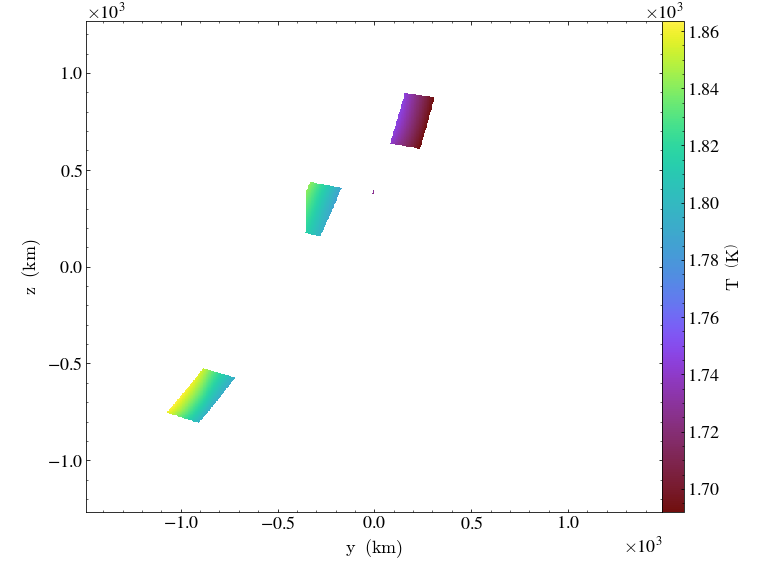

In [12]:
p=yt.SlicePlot(ds, "x", ("connect1", "T"))
p.set_log("T",False)
p.show()

so units are there! but that's slicing just a single mesh element. 

yt : [INFO     ] 2020-08-26 08:47:12,337 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-08-26 08:47:12,337 ylim = -3272029.003993 -736270.698742
yt : [INFO     ] 2020-08-26 08:47:12,338 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-08-26 08:47:12,338 ylim = -3272029.003993 -736270.698742
yt : [INFO     ] 2020-08-26 08:47:12,339 Making a fixed resolution buffer of (('all', 'T')) 800 by 800



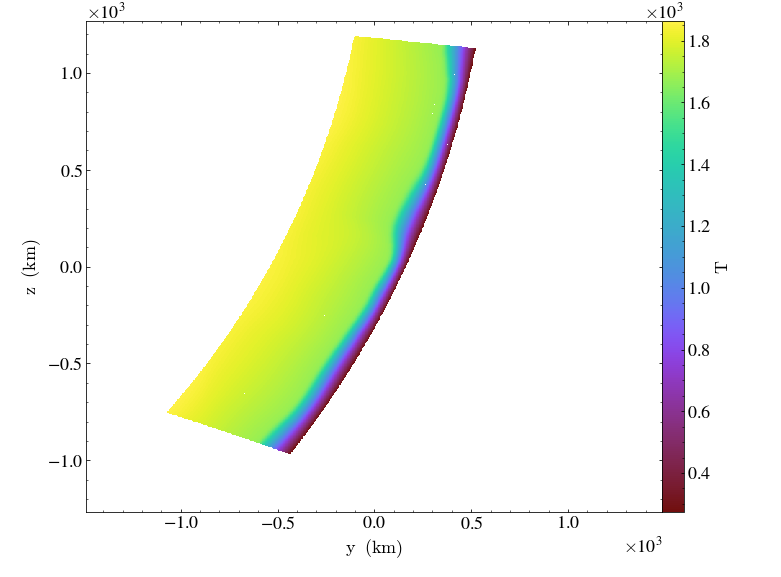

In [13]:
p=yt.SlicePlot(ds, "x", ("all", "T"))
p.set_log("T",False)
p.show()

hmm. `fluid_type` of `all` doesn't seem to keep the units??? need to map out what `all` actually is... 